# Link between GitHub repository and ExTRI2 paper
A notebook containing links to, or code for, generating the figures, tables, and results for the ExTRI2 paper, divided by the different sections in the paper.

Go to each section to see the analysis done, or a link to the script/notebook that contains the information.

In [2]:
__import__('sys').path.append('../scripts/common/'); __import__('notebook_utils').table_of_contents('repo_to_paper.ipynb')

<h3>Table of contents</h3>


[Link between GitHub repository and ExTRI2 paper](#Link-between-GitHub-repository-and-ExTRI2-paper)
- [Setup & configuration](#Setup-&-configuration)
- [0. Unorganised analysis functions](#0.-Unorganised-analysis-functions)
- [2.1. Overview of the ExTRI2 pipeline](#2.1.-Overview-of-the-ExTRI2-pipeline)
- [2.2. Data sources and preparation](#2.2.-Data-sources-and-preparation)
  - [2.2.1 Retrieving annotated abstracts from PubTator3](#2.2.1-Retrieving-annotated-abstracts-from-PubTator3)
  - [2.2.2 Retrieving TF Gene IDs from TFCheckpoint and GO annotations](#2.2.2-Retrieving-TF-Gene-IDs-from-TFCheckpoint-and-GO-annotations)
- [2.3 Curated dataset for training – The NTNU collection & 3.1 The NTNU collection](#2.3-Curated-dataset-for-training-–-The-NTNU-collection-&-3.1-The-NTNU-collection)
- [2.4. Classifier configuration and training & 3.3.1. Classifiers performance](#2.4.-Classifier-configuration-and-training-&-3.3.1.-Classifiers-performance)
- [2.5 Improvement of the training dataset](#2.5-Improvement-of-the-training-dataset)
  - [2.5.1 Sentence splitter](#2.5.1-Sentence-splitter)
  - [2.5.2 Iterative classifier training and dataset revision](#2.5.2-Iterative-classifier-training-and-dataset-revision)
- [2.6. Validation criteria and process & 3.3.2. Manual validation outcomes](#2.6.-Validation-criteria-and-process-&-3.3.2.-Manual-validation-outcomes)
  - [Negations - observations](#Negations---observations)
- [3.2. The ExTRI2 resource](#3.2.-The-ExTRI2-resource)

## Setup & configuration

In [45]:
# IMPORTS
import pandas as pd
import numpy as np
import os
import json
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import upsetplot
import warnings
from analysis import *


from Bio import Entrez
# *Always* tell NCBI who you are
Entrez.email = "example24@gmail.com"

## Custom functions
import sys

sys.path.append('../scripts/common/')
from notebook_utils import h3, h4, h5, md
from analysis import load_config
pd.set_option('display.max_colwidth', 20)

In [46]:
# LOAD DATA
config = load_config()

# Load ExTRI dataset
ExTRI2_df = pd.read_csv(config['final_ExTRI2_p'], sep="\t", dtype=str, keep_default_na=False)
# Add columns to ExTRI2 df to facilitate analysis
ExTRI2_df['TRI Id']             = ExTRI2_df['TF Id'] + '|' + ExTRI2_df['TG Id']

# Load the validation dataset
validated_df           = pd.read_csv(config['final_validated_p'], sep='\t', header=0, dtype=str)

# Load the supp. file with all TF IDs, and modify TF type
TFs_df = pd.read_csv("tables/all_TFs.tsv", sep="\t", dtype=str)

# Drop validated_df repeated column
assert (validated_df['TF_type_validated'] == validated_df['TF_type']).all(), "The TF types in the validated df have been modified!"
validated_df.drop(columns=['TF_type_validated'], inplace=True)

In [47]:
# CHANGE THE TF TYPE TO THE NEW CATEGORISATION FOR VALIDATED DF & ExTRI2

def modify_TF_type(df, TFs_df):
    '''
    Modify the "TF_type" column of df by the new categorisation present in TFs_df.
    Rows with no TF type are marked as "-" and then removed.
    '''

    # Build the mapping dict
    id_to_type = dict(zip(
        TFs_df['Gene ID'].astype(str),
        TFs_df['updated TF type'].fillna('-').astype(str)
    ))
    # Add NFKB and AP1 complexes
    id_to_type['Complex:NFKB'] = 'dbTF'
    id_to_type['Complex:AP1'] = 'dbTF'

    # Make sure all unclassified genes are marked with "-"
    assert (set(id_to_type.values()) == {'dbTF', 'coTF', 'coTF candidate', '-'}), "Unexpected TF types found in the mapping dict"

    # Function to map IDs
    def map_ids(row):
        return ";".join(
            id_to_type.get(x.strip(), '-')   # use "-" if unknown
            for x in row['TF Id'].split(";")
        )

    df['new_TF_type'] = df.apply(map_ids, axis=1)

    # Show the difference between old and new TF types
    md("Difference between old and new TF types:")
    display(df[['TF_type', 'new_TF_type']].value_counts(dropna=False))

    # Replace old TF_type by new_TF_type
    df.drop(columns=['TF_type'], inplace=True)
    df.rename(columns={'new_TF_type': 'TF_type'}, inplace=True)

    # Remove rows with no TF type (all "-")
    n_before = len(df)
    df = df[df['TF_type'].str.split(";").apply(lambda x: set(x) != {'-'})]
    n_after = len(df)
    md(f"Removed {n_before - n_after} ({(n_before - n_after) / n_before:.2%}) rows with no TF type ({n_before} -> {n_after})")

    return df


# Modify both validated_df & ExTRI2_df to the new categorisation
md("Validated df:")
validated_df = modify_TF_type(validated_df, TFs_df)
md("ExTRI2 df:")
ExTRI2_df = modify_TF_type(ExTRI2_df, TFs_df)

# Save the modified dataframes
validated_df.to_csv(config['paper_ExTRI2_p'], sep="\t", index=False)
ExTRI2_df.to_csv(config['paper_validated_p'], sep="\t", index=False)

# Make the 3 categories ordinal for validated_df
tf_types = ['dbTF', 'coTF', 'coTF candidate']
validated_df['TF_type'] = pd.Categorical(
    validated_df['TF_type'],
    categories=tf_types,
    ordered=True
)

Validated df:

Difference between old and new TF types:

TF_type  new_TF_type   
dbTF     dbTF              3448
ll_coTF  coTF candidate    1312
coTF     coTF candidate    1223
         coTF               607
ll_coTF  coTF                74
coTF     -                   51
dbTF     coTF candidate      47
         -                   33
         coTF                18
ll_coTF  -                   14
coTF     dbTF                 8
Name: count, dtype: int64

Removed 98 (1.43%) rows with no TF type (6835 -> 6737)

ExTRI2 df:

Difference between old and new TF types:

TF_type                  new_TF_type                            
dbTF                     dbTF                                       419327
ll_coTF                  coTF candidate                             200338
coTF                     coTF candidate                             104211
                         coTF                                        80703
ll_coTF;ll_coTF          coTF candidate;coTF candidate                9792
                                                                     ...  
coTF;coTF;coTF;coTF      coTF;coTF;coTF candidate;coTF                   1
                         coTF candidate;coTF;coTF candidate;coTF         1
coTF;coTF;coTF           coTF;coTF candidate;dbTF                        1
coTF;coTF;-;-;-;-        coTF candidate;-;-;-;-;-                        1
ll_coTF;ll_coTF;ll_coTF  coTF candidate;coTF;coTF candidate              1
Name: count, Length: 155, dtype: int64

Removed 3479 (0.42%) rows with no TF type (835522 -> 832043)

## 0. Unorganised analysis functions

Some general analysis of ExTRI2 not relevant for the paper

In [6]:
# TODO - Remove this if it is irrelevant for the paper
def show_analytics(label, num, total):
    total_len = total if type(total) is int else len(total)
    num_len = num if type(num) in (int, np.int64) else len(num)
    print(f'{label:30}{num_len:,}/{total_len:<10,}{num_len/total_len:>10.2%}')

def display_uniques():
    h3("Unique values")
    m_cols = ['#SentenceID', 'Sentence', 'PMID', 'TRI Id', 'PMID+Sent+TRI_Id', '',
            'Valid', 'MoR', 'TF_type', 'TF TaxID', 'TG TaxID', '',
            'TF', 'TF Id', 'TF Symbol', 'TF_human_entrez_gene', 'TF_hgnc_id', 'TF_human_symbol', '',
            'TG', 'TG Id', 'TG Symbol', 'TG_human_entrez_gene', 'TG_hgnc_id', 'TG_human_symbol'] 

    total = len(ExTRI2_df)
    for col in m_cols:
        if col == '':
            print()
            continue
        num = ExTRI2_df[col].unique()
        show_analytics(f'Unique {col}', num, total)

def display_NA_values():
    h3("Columns with Na values")
    cols_to_ignore = ['tags', 'renormalisation']

    total = len(ExTRI2_df)
    for col in ExTRI2_df.columns:
        col_has_na = max(int(ExTRI2_df[col].isna().sum()), int((ExTRI2_df[col] == '').sum()))
        if col_has_na & (col not in cols_to_ignore):
            show_analytics(f'{col}', col_has_na, total)

def display_cols_with_colons():
    h3("Columns with colons (;)")
    colon_cols = ['TF_type', 'TF TaxID', 'TG TaxID', '',
            'TF', 'TF Id', 'TF Symbol', 'TF_human_entrez_gene', 'TF_hgnc_id', 'TF_human_symbol', '',
            'TG', 'TG Id', 'TG Symbol', 'TG_human_entrez_gene', 'TG_hgnc_id', 'TG_human_symbol']

    total = len(ExTRI2_df)
    for col in colon_cols:
        if col == '':
            print()
            continue
        num = int(ExTRI2_df[col].str.contains(';').sum())
        show_analytics(f'{col}', num, total)


    h3("Number of unique rows with ;")
    for col in colon_cols:
        if col == '':
            print()
            continue
        if ExTRI2_df[col].isna().sum() != 0:
            continue
        m = ExTRI2_df[col].str.contains(';')
        num = ExTRI2_df[m][col].unique()
        num_un = ExTRI2_df[col].unique()
        show_analytics(f'{col}', num, num_un)

def display_TF_types():
    h3("Joined TF Types")
    squished = ExTRI2_df['TF_type'].apply(lambda x: ";".join(set(x.split(';'))))
    print(squished.value_counts())
    print()

def display_unique_content_per_col():
    h3("Columns with <30 unique values")
    for col in ExTRI2_df.columns:
        uniq = ExTRI2_df[col].unique()
        if len(uniq) < 30:
            print(f"{col:25}{len(uniq):<10}{', '.join(uniq.astype(str))}")
        else:
            print(f"{col:25}{len(uniq):<10}{', '.join(uniq[:2])}")

display_uniques()
display_cols_with_colons()
display_TF_types()
display_unique_content_per_col()

<h3>Unique values</h3>

Unique #SentenceID            832,043/832,043      100.00%
Unique Sentence               830,812/832,043       99.85%
Unique PMID                   291,851/832,043       35.08%
Unique TRI Id                 282,440/832,043       33.95%
Unique PMID+Sent+TRI_Id       832,043/832,043      100.00%

Unique Valid                  1/832,043        0.00%
Unique MoR                    3/832,043        0.00%
Unique TF_type                91/832,043        0.01%
Unique TF TaxID               20/832,043        0.00%
Unique TG TaxID               22/832,043        0.00%

Unique TF                     23,849/832,043        2.87%
Unique TF Id                  7,013/832,043        0.84%
Unique TF Symbol              6,032/832,043        0.72%
Unique TF_human_entrez_gene   4,716/832,043        0.57%
Unique TF_hgnc_id             4,713/832,043        0.57%
Unique TF_human_symbol        4,713/832,043        0.57%

Unique TG                     55,376/832,043        6.66%
Unique TG Id                  25,

<h3>Columns with colons (;)</h3>

TF_type                       16,512/832,043        1.98%
TF TaxID                      16,512/832,043        1.98%
TG TaxID                      8,086/832,043        0.97%

TF                            68/832,043        0.01%
TF Id                         16,512/832,043        1.98%
TF Symbol                     16,512/832,043        1.98%
TF_human_entrez_gene          104,031/832,043       12.50%
TF_hgnc_id                    103,978/832,043       12.50%
TF_human_symbol               103,978/832,043       12.50%

TG                            8/832,043        0.00%
TG Id                         8,086/832,043        0.97%
TG Symbol                     8,086/832,043        0.97%
TG_human_entrez_gene          86,730/832,043       10.42%
TG_hgnc_id                    86,694/832,043       10.42%
TG_human_symbol               86,694/832,043       10.42%


<h3>Number of unique rows with ;</h3>

TF_type                       88/91            96.70%
TF TaxID                      17/20            85.00%
TG TaxID                      19/22            86.36%

TF                            42/23,849         0.18%
TF Id                         1,193/7,013         17.01%
TF Symbol                     1,137/6,032         18.85%
TF_human_entrez_gene          1,888/4,716         40.03%
TF_hgnc_id                    1,885/4,713         40.00%
TF_human_symbol               1,885/4,713         40.00%

TG                            8/55,376         0.01%
TG Id                         1,959/25,725         7.62%
TG Symbol                     1,896/22,840         8.30%
TG_human_entrez_gene          4,614/17,493        26.38%
TG_hgnc_id                    4,609/17,489        26.35%
TG_human_symbol               4,609/17,490        26.35%


<h3>Joined TF Types</h3>

TF_type
dbTF                        424343
coTF candidate              316903
coTF                         87777
-;coTF candidate              1368
coTF candidate;coTF            500
-;coTF                         416
dbTF;coTF                      386
-;dbTF                         141
dbTF;-                         120
dbTF;coTF candidate             56
dbTF;coTF candidate;coTF        12
-;coTF candidate;dbTF            8
-;coTF candidate;coTF            8
-;dbTF;coTF                      5
Name: count, dtype: int64



<h3>Columns with <30 unique values</h3>

#SentenceID              832043    PMID:35388756:pubtator_title_and_abstract:cb4217d25fb4d7c895812e2f96ae2628:9:CHCHD2:GNPTG:1366:1458, PMID:26808438:pubtator_title_and_abstract:42c92af80826602081a3eaf43b49d551:7:ChREBP:Mid1ip1,Txnip:919:1050
Sentence                 830812    Chip-IP results showed that [TF] might regulate potential target genes such as HDX, ACP1, RAVER2, C1orf229, RN7SL130, [TG], erythroid 2 Like 2 (NFE2L2), required for cell differentiation 1 homologue (RQCD1), solute carrier family 5 member 7 (SLA5A7), and NAcetyltransferase 8 Like (NAT8L)., Among multiple ChREBP-controlled genes, [TF] was sufficient and necessary for regulation of Eno1, Pklr, Mdh1, Me1, Pdha1, Acly, Acaca, Fasn, Elovl6, Gpd1, Cpt1a, Rgs16, [TG], and Chrebpbeta.
TF                       23849     CHCHD2, ChREBP
TG                       55376     GNPTG, Mid1ip1,Txnip
TF Id                    7013      51142, 51085
TG Id                    25725     84572, 58526;10628
TF offset                3448   

## 2.1. Overview of the ExTRI2 pipeline

Scripts used for the different parts of the pipeline:
1. **Abstracts and Entity Extraction:** See [scripts/preprocessing/README.md](../scripts/preprocessing/README.md) for a description of the different scripts used
2. **Abstract Segmentation and Candidate Sentences Creation:** [workflow.rb](../workflow.rb)
3. **Identification of TRIs and their MoR:** [workflow.rb](../workflow.rb), using classifiers trained with [classifiers_training/run_classifiers.sh](../classifiers_training/run_classifiers.sh)
4. **Post-processing and normalization:** [postprocessing.py](../scripts/postprocessing/postprocessing.py) and [postprocessing_checkings.ipynb](../scripts/postprocessing/postprocessing_checkings.ipynb)

## 2.2. Data sources and preparation

### 2.2.1 Retrieving annotated abstracts from PubTator3
See [get_all_pubtators.sh](../scripts/preprocessing/get_all_pubtators.sh)

### 2.2.2 Retrieving TF Gene IDs from TFCheckpoint and GO annotations
See [get_NCBI_TF_IDs.ipynb](../scripts/preprocessing/get_NCBI_TF_IDs.ipynb)

## 2.3 Curated dataset for training – The NTNU collection & 3.1 The NTNU collection

See [update_tri_sentences.ipynb](../scripts/classifiers_training/update_tri_sentences.ipynb) for details on how the final_NTNU_df was created.

In [7]:
# Original annotated sentences
original_NTNU_df = pd.read_csv('../data/external/original_tri_sentences.tsv', sep='\t', skiprows=1)

# Sentences used for training the models (where suboptimal sentences are "Not TRI")
training_df = pd.read_csv('../classifiers_training/data/tri_sentences.tsv', sep='\t')

# Final NTNU dataset
final_NTNU_df = pd.read_csv('../results/NTNU_dataset.tsv', sep='\t')

def display_NTNU_analysis():
    md("Comparison of original and final NTNU datasets")
    NTNU_analysis = {'Original': {}, 'Final': {}}

    for name, df in [('Original', original_NTNU_df), ('Final', final_NTNU_df)]: 
        NTNU_analysis[name]['Total'] = len(df)
        NTNU_analysis[name]['Unique'] = len(df[['Sentence', 'TF', 'TG']].drop_duplicates())
        NTNU_analysis[name]['Duplicated'] = (df[['Sentence', 'TF', 'TG']].duplicated().sum())


        for TRI in [False, True]:
            NTNU_analysis[name][TRI] = len(df[df['Label'] == TRI])
        for MoR in ['UNDEFINED', 'ACTIVATION', 'REPRESSION']:
            NTNU_analysis[name][MoR] = len(df[df['Type'] == MoR])
            
    NTNU_analysis = pd.DataFrame.from_dict(NTNU_analysis)
    NTNU_analysis['difference'] = NTNU_analysis['Final'] - NTNU_analysis['Original']

    display(NTNU_analysis.map(lambda x: f"{x:,}" if isinstance(x, int) else x))

def analyse_NTNU_normalisation():

    # Get normalised TF & TG columns
    final_NTNU_df['norm TF'] = final_NTNU_df["#TRI ID"].apply(lambda x: x.split(":")[2])
    final_NTNU_df['norm TG'] = final_NTNU_df["#TRI ID"].apply(lambda x: x.split(":")[3])

    md("Number of unique TF and TG in the final NTNU dataset")
    rows = []

    for label in ("TRI", "Not TRI", "Total"):
        for TX in ["TF", "TG"]:   
            # Get subset, if necessary
            subset = final_NTNU_df if label == "Total" else final_NTNU_df[final_NTNU_df['Label'] == label]

            # Extract relevant info
            rows.append({
                "Subset": label,
                "Type": TX,
                "Mention": subset[TX].nunique(),
                "Normalised": subset[f"norm {TX}"].nunique()
            })

    summary_df = pd.DataFrame(rows)
    display(summary_df.pivot(index="Subset", columns="Type", values=["Mention", "Normalised"]))

    # Load all TFs
    all_TFs_df = pd.read_csv('tables/all_TFs.tsv', sep='\t', dtype=str)
    TFs_symbols = set(all_TFs_df['Symbol'].str.upper())

    # Get normalised TFs in the TF list
    normalised_TFs = set(final_NTNU_df['norm TF'].str.upper())
    normalised_TFs_in_TF_list = normalised_TFs.intersection(TFs_symbols)

    md(f"Number of normalised TFs in the TF list: {len(normalised_TFs_in_TF_list)}/{len(normalised_TFs)} ({len(normalised_TFs_in_TF_list)/len(normalised_TFs):.2%})")
    md("Most common TFs outside the TF list:")

    print(len(TFs_symbols), TFs_symbols)
    m = ~final_NTNU_df['norm TF'].str.upper().isin(list(TFs_symbols))
    display(final_NTNU_df[m]['norm TF'].value_counts().head(30))


display_NTNU_analysis()
analyse_NTNU_normalisation()

Comparison of original and final NTNU datasets

,Original,Final,difference
Total,"22,135","21,501",-634
Unique,"21,766","21,501",-265
Duplicated,369,0,-369
False,"10,986",0,"-10,986"
True,"11,149",0,"-11,149"
UNDEFINED,"3,884","4,073",189
ACTIVATION,"5,339","5,395",56
REPRESSION,"1,926","2,053",127


Number of unique TF and TG in the final NTNU dataset

Mention       Normalised      
Type         TF    TG         TF    TG
Subset                                
Not TRI    1579  3043       1198  2571
TRI        1653  3171       1088  2304
Total      2194  5150       1395  3883

Number of normalised TFs in the TF list: 663/1243 (53.34%)

Most common TFs outside the TF list:

4087 {'ZNF692', 'ZFP263', 'ACSS2', 'MSL3', 'DNAAF4', 'FOXG1', 'ENO1', 'H2AC7', 'ZFP872', 'PHF14', 'ASIP', 'ZNF254', 'ZNF280A', 'RNF14', 'HOXD8', 'ZNF84', 'PER2', 'LOC108348112', 'VGLL4', 'ZNF543', 'ZNF34', 'PUS1', 'HNF4A', 'HEY2', 'ZFP579', 'ZFP133', 'ZNF597', 'HDX', 'PHTF2', 'ZNF223', 'ZFP3', 'SPIC', 'DUSP22', 'ZFP607A', 'TIMELESS', 'PPP3CA', 'FANCD2', 'H2AJ', 'MAP2K1', 'CBFA2T2', 'LEF1', 'ZNF423', 'CRTC3', 'SAP18', 'TRIM21', 'ZNF146', 'MLXIP', 'TCF12', 'ZNF627', 'ZFP488', 'ZFP93', 'SKIL', 'FAF1', 'VGLL1', 'OBOX1', 'ZSCAN5C', 'EEA1', 'APEX1', 'TERT', 'HNRNPU', 'ZFP14', 'SSBP4', 'RNF141', 'IFI205', 'ERF', 'UTP4', 'CCDC59', 'ZBTB12', 'ATF4', 'ATF7IP', 'ZNF112', 'POLR3C', 'TFAP2C', 'FBXL19', 'NOTCH3', 'CIPC', 'MED31', 'FLT3', 'PPIE', 'ZSCAN4D', 'MAFF', 'CDYL', 'SMYD5', 'ZNF324', 'NEUROG1', 'ZNF768', 'LOC100359916', 'RHOXF5', 'POU2F2', 'RRP8', 'DUXB', 'HEY1', 'NELFA', 'LOC124909084', 'ZBTB8A', 'NUP107', 'WIPI1', 'DUX1', 'PRAMEF20', 'PAX4', 'H3-4', 'ZNF76', 'DLL1', 'BORCS8-MEF2B', 'ZFP385A

norm TF
NFKB                       769
AP1                        430
p53                        154
SF-1                       107
AP-1                        96
NF-kappaB                   83
Ets                         59
CREB                        57
ER                          49
androgen receptor           48
ERalpha                     46
LXR                         42
Egr-1                       41
c-Jun                       40
LRH-1                       37
FXR                         34
NF-Y                        33
androgen                    32
c-myc                       31
DAX-1                       31
p50                         31
steroidogenic factor-1      30
c-Myc                       28
p65                         28
SREBP-1c                    27
glucocorticoid receptor     26
PXR                         25
RXR                         24
farnesoid X receptor        24
ERbeta                      24
Name: count, dtype: int64

In [8]:
# Check normalised NTNUs
# TODO - finish & order these cells, only keep the relevant parts.
# Show Astrid & miguel to decide what to do: should NTNU contain normalised TF/TGs, if they're incorrect?

# Get normalised TF & TG
final_NTNU_df_extra = final_NTNU_df.copy()
final_NTNU_df_extra['norm TF'] = final_NTNU_df_extra["#TRI ID"].apply(lambda x: x.split(":")[2])
final_NTNU_df_extra['norm TG'] = final_NTNU_df_extra["#TRI ID"].apply(lambda x: x.split(":")[3])

# See how many symbols are present in the TF list
all_TFs_df = pd.read_csv('tables/all_TFs.tsv', sep='\t', dtype=str)

all_TFs_df.head()

,Gene ID,TF type,Symbol,TaxID,GO:0003700,GO:0003712,GO:0001098,GO:0002039,GO:0008134,GO:0042393,...,tcof_cotf_human.present,tcof_cotf_mouse.present,TFclass_human,TFclass_mouse,TFclass_rat,updated TF type,In ExTRI,human_entrez_gene,hgnc_id,human_symbol
0,18617,dbTF,Rhox5,10090,GO:0001228,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,dbTF,True,NaN,NaN,NaN
1,245525,dbTF,Hsf3,10090,GO:0003700,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,TFclass_mouse.pr...,NaN,dbTF,True,NaN,NaN,NaN
2,29589,dbTF,Pou3f4,10116,GO:0000981;GO:00...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,TFclass_rat.present,dbTF,True,7920;5456,HGNC:13921;HGNC:...,ABHD16A;POU3F4
3,84472,dbTF,Ilf3,10116,GO:0003700,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,dbTF,True,51104;3609,HGNC:24278;HGNC:...,ABHD17B;ILF3
4,54608,dbTF,Abhd2,10090,GO:0003707,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,dbTF,True,11057,HGNC:18717,ABHD2


In [9]:
# Save into "tables/" in the correct format
def save_NTNU_dataset(final_NTNU_df):
    "Change NTNU dataset so it has the expected format of the paper"
    paper_NTNU = final_NTNU_df.copy()

    # Rename columns to match the paper format
    paper_NTNU.rename(columns={'Label': 'TRI', 'Type': 'MoR'}, inplace=True)
    paper_NTNU['TRI'] = paper_NTNU['TRI'].replace({False: 'Not TRI', True: 'TRI'})

    # Save into tables
    pd.DataFrame.to_csv(paper_NTNU, "tables/NTNU_dataset.tsv", index=False, header=True)

    display(paper_NTNU.head())

save_NTNU_dataset(final_NTNU_df)

,#TRI ID,Sentence,TF,TG,TRI,MoR,norm TF,norm TG
0,16373364:0:Ets1:...,"A role for Ets1,...",Ets1,GATA-3,Not TRI,NaN,Ets1,GATA-3
1,16373364:0:Ets1:...,"A role for Ets1,...",Ets1,IL-5,TRI,UNDEFINED,Ets1,IL-5
2,16373364:0:Ets1:...,"A role for Ets1,...",Ets1,AP-1,Not TRI,NaN,Ets1,AP-1
3,16373364:0:GATA-...,"A role for Ets1,...",GATA-3,Ets1,Not TRI,NaN,GATA-3,Ets1
4,16373364:0:GATA-...,"A role for Ets1,...",GATA-3,IL-5,TRI,UNDEFINED,GATA-3,IL-5


## 2.4. Classifier configuration and training & 3.4.1. Classifiers performance

**2.4**<br>
Facts stated in the text
* Train-test split is 85:15 - [src/dataset.py](../classifiers_training/src/dataset.py)
* **Table S3:** Values obtained from [classifiers_comparison.ipynb/Final iteration](classifiers_comparison.ipynb)
* **Table S4 and Table S5:** Values obtained from [classifiers_comparison.ipynb/Previous iterations](classifiers_comparison.ipynb)

**3.4.1.**<br>
Final models F1 score on test dataset: 0.94 for TRI and 0.95 for MoR. Obtained from [classifiers_comparison.ipynb/Final models](classifiers_comparison.ipynb). There is also a confusion matrix there.

## 2.5 Improvement of the training dataset

### 2.5.1 Sentence splitter
From [update_tri_sentences.ipynb#Modify_joined_sentences](../scripts/classifiers_training/update_tri_sentences.ipynb) we extract the claim that "sciSpacy detected 54 sentences (0.25% of the dataset) that required further splitting. They were discarded"

### 2.5.2 Iterative classifier training and dataset revision
**Facts stated in the text:**
* We revised **3111 sentences** (14.4% of the dataset) ([prepare_reannotation_Excels.ipynb#Compare original and revised datasets](../scripts/classifiers_training/prepare_reannotation_Excels.ipynb)):
  *  3086 from the original NTNU dataset plus 25 extra negative sentences. We modified the label in **1991** of those sentences [update_tri_sentences.ipynb#Reannotations](../scripts/classifiers_training/update_tri_sentences.ipynb)

Figures and tables:
* **Figure 5** made in [prepare_reannotation_Excels.ipynb#Compare original and revised datasets](../scripts/classifiers_training/prepare_reannotation_Excels.ipynb)
* **Table 6** can partly be found in [prepare_reannotation_Excels.ipynb#Compare original and revised datasets](../scripts/classifiers_training/prepare_reannotation_Excels.ipynb) but standard deviation and MoR classifiers data is obtained from [classifiers_comparison.ipynb](classifiers_comparison.ipynb)
* **Table S11** in [prepare_reannotation_Excels.ipynb#Comparison of the worst predicted sentences (threshold=0.2) between the different iterations](../scripts/classifiers_training/prepare_reannotation_Excels.ipynb)

## 2.6. Validation criteria and process & 3.3.2. Manual validation outcomes

In [10]:
# Save validated_df in the format specified in the paper
def save_paper_validated_df(validated_df):
    '''Get the validated_df in the format specified in the paper'''

    # Only keep relevant columns
    columns = ['#SentenceID', 'Sentence', 'Label', 'MoR', 'Valid?', 'true_label', 'true_MoR', 'Valid score', 'MoR scores',  # TRI - MoR validation
               'TF', 'TF Id', 'TF Symbol', 'TF TaxID',  'TF_is_incorrect', 'TF_correct_mention', 'TF offset',               # TF validation
               'TG',  'TG Id', 'TG Symbol', 'TG TaxID', 'TG_is_incorrect', 'TG_correct_mention', 'Gene offset',             # TG validaiton
               'method', 'stage', 'renormalisation', 'pre-post', 'TF_type',                                                 # Metadata
               'Other issues', 'Explanation'
               ]
    
    # Only keep relevant columns
    paper_val_df = validated_df[columns].copy()

    # Change column names to match with paper
    paper_val_df.rename(columns={'Label': 'TRI', 'true_label': 'true_TRI', 'Valid score': 'TRI score'}, inplace=True)

    # Change TRI labels to match with paper
    paper_val_df['TRI'] = paper_val_df['TRI'].replace({'FALSE': 'Not TRI', 'TRUE': 'TRI'})
    paper_val_df['true_TRI'] = paper_val_df['true_TRI'].replace({'FALSE': 'Not TRI', 'TRUE': 'TRI'})    
    
    # Save into "tables/" folder
    pd.DataFrame.to_csv(paper_val_df, "tables/all_validated_sentences.tsv", sep='\t', index=False, header=True)

    display(paper_val_df.head())
    
    return

save_paper_validated_df(validated_df)

,#SentenceID,Sentence,TRI,MoR,Valid?,true_TRI,true_MoR,TRI score,MoR scores,TF,...,TG_is_incorrect,TG_correct_mention,Gene offset,method,stage,renormalisation,pre-post,TF_type,Other issues,Explanation
0,10490613:2:NF-ka...,A hallmark of in...,TRI,ACTIVATION,F,Not TRI,NaN,NaN,0.00833613522600...,NF-kappaB.,...,NaN,NaN,538,random,s1,NFKB,pre,dbTF,Splitter,NaN
1,34564314:2:TP53:...,Long non-coding ...,TRI,UNDEFINED,T,TRI,UNDEFINED,NaN,0.99718615402933...,TP53,...,NaN,NaN,160,random,s1,NaN,pre,dbTF,NaN,NaN
2,33916908:6:NRF2:EGF,ChIP sequencing ...,TRI,UNDEFINED,T,TRI,UNDEFINED,NaN,0.99766902869249...,NRF2,...,NaN,NaN,876,random,s1,NaN,pre,dbTF,NaN,NaN
3,33766982:4:Camta...,"In this study, w...",TRI,UNDEFINED,F,Not TRI,NaN,NaN,0.99678953469570...,Camta1,...,NaN,NaN,479,random,s1,NaN,pre,coTF,NaN,NaN
4,32972752:0:SETDB...,Knockout of [TF]...,TRI,REPRESSION,F,TRI,UNDEFINED,NaN,0.01346601239389...,SETDB1,...,NaN,NaN,129,random,s1,NaN,pre,dbTF,mutation,NaN


TF distribution for the three TF types for the random and balanced datasets (pre post-processing rules)

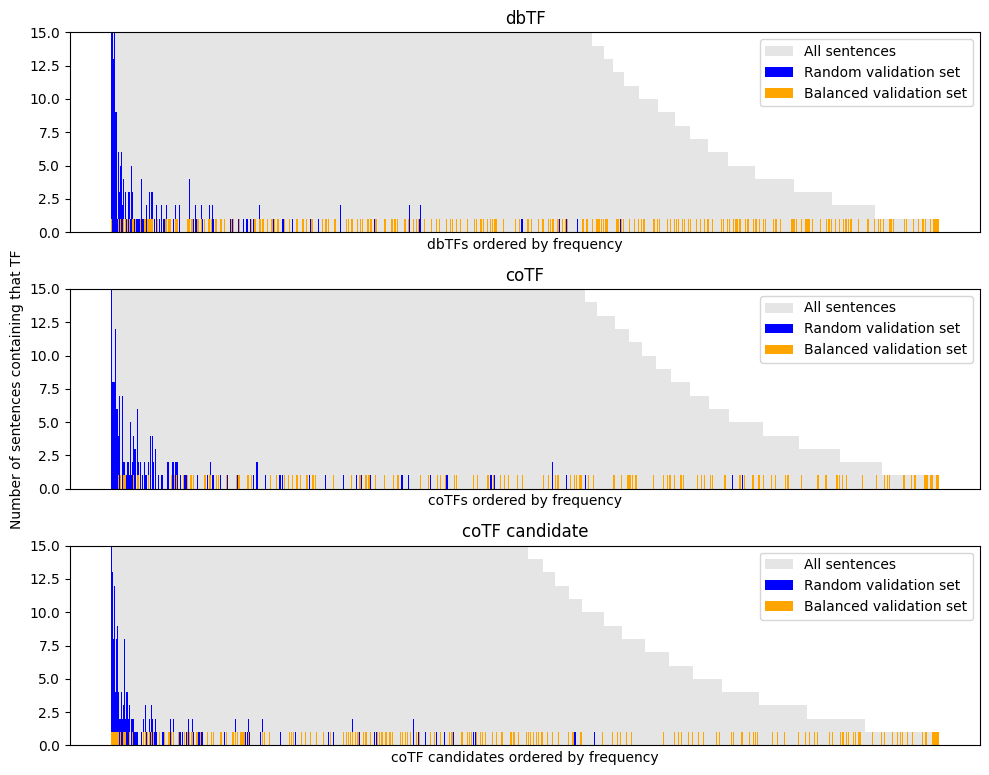

TF distribution for the three TF types for the random and balanced datasets (post post-processing rules)

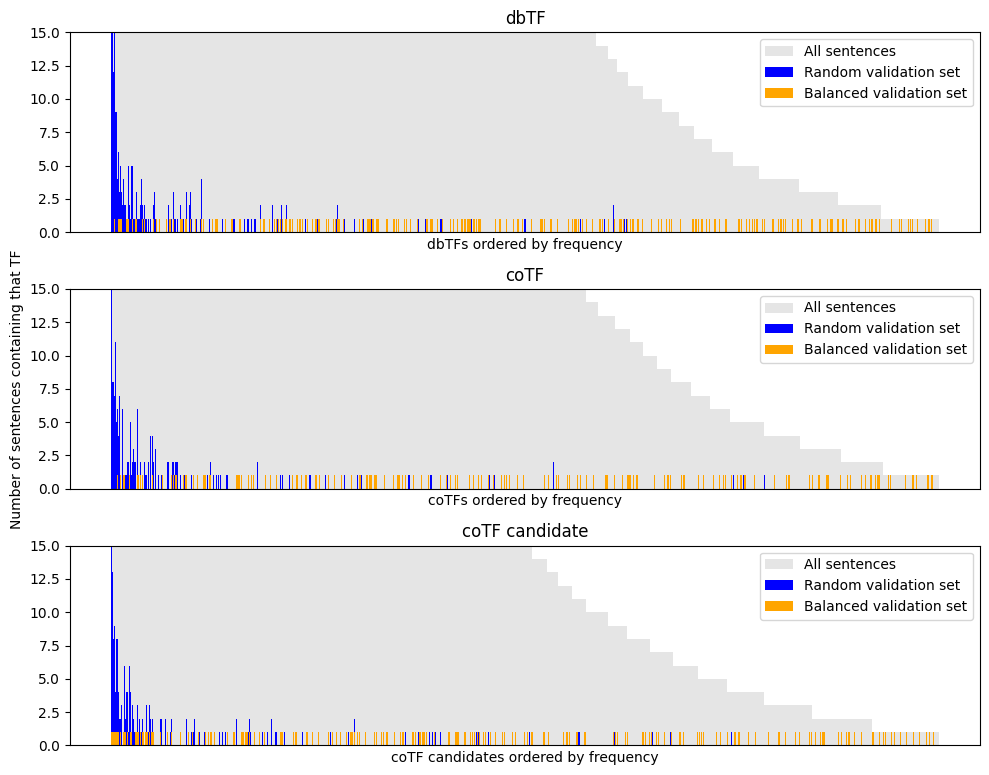

In [12]:
# PLOT - Ensure correctly balanced validation dataset
def plot_tf_validation_distribution(ax, tf_type: str, all_sents: pd.DataFrame, val_random: pd.DataFrame, val_balanced: pd.DataFrame, ylim=30):
    for df, label, color, alpha in [
        (all_sents, "All sentences", "grey", 0.2),
        (val_random, "Random validation set", "blue", 1),
        (val_balanced, 'Balanced validation set', "orange", 1)
    ]:
        counts = df['TF Id'].value_counts()
        ax.bar(counts.index, counts, label=label, color=color, alpha=alpha, width=1)
    ax.set_title(tf_type)
    ax.set_xticks([])
    #plt.xticks(rotation='vertical')
    ax.set_xlabel(f"{tf_type}s ordered by frequency")
    ax.set_ylim((0,ylim))
    ax.legend()

def plot_all_tf_validation_distributions(title, ExTRI2_df, validated_1mapping, figsize=(15, 10), ylim=30):

    fig, axes = plt.subplots(3, 1, figsize=figsize)
    for i, TF_type in enumerate(validated_1mapping['TF_type'].cat.categories):
        TRI_subset = ExTRI2_df[ExTRI2_df['TF_type'] == TF_type]
        validated_subset = validated_1mapping[(validated_1mapping['TF_type'] == TF_type)]

        validated_subset_b = validated_subset[validated_subset['method'] == 'balanced']
        validated_subset_r = validated_subset[validated_subset['method'] == 'random']

        plot_tf_validation_distribution(axes[i], TF_type, TRI_subset, val_balanced = validated_subset_b, val_random = validated_subset_r, ylim=ylim)
    axes[1].set_ylabel(f"Number of sentences containing that TF")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

for pre_post in ["pre", "post"]:
    md(f"TF distribution for the three TF types for the random and balanced datasets ({pre_post} post-processing rules)")
    plot_all_tf_validation_distributions("", ExTRI2_df, validated_df[(validated_df['pre-post'] == pre_post) & (validated_df['Label'] == 'TRUE')], figsize=(10, 8), ylim = 15)

In [13]:
def evaluate_other_issues(validated_df):
    h3("Other issues")

    # Get sentences where there are other issues
    o_i = validated_df.drop_duplicates(subset=['#SentenceID'], keep='first').dropna(subset=['Other issues'])

    # Display common issues
    display(o_i['Other issues'].apply(lambda x: x.split(';')).explode().value_counts())

    # Get uniquely validated sentences
    validated_unique = validated_df.drop_duplicates(subset=['#SentenceID'], keep='first')

    # Splitter / suboptimal / dir-gene issues
    m = validated_unique['Other issues'].fillna('').str.contains('Splitter')
    print(f"{m.sum()}/{len(m)} ({m.sum()/len(m):.1%}) sentences are incorrecty splitted")
    m = validated_unique['Other issues'].fillna('').str.contains('suboptimal')
    print(f"{m.sum()}/{len(m)} ({m.sum()/len(m):.1%}) sentences are suboptimal")
    m = validated_unique['dir-*'].fillna('') == 'dir-gene'
    print(f"{m.sum()}/{len(m)} ({m.sum()/len(m):.1%}) sentences classified as 'dir-gene")

    # Check for more common issues, what proportion of the dataset do they appear in
    results = []
    for tf_type in validated_df['TF_type'].cat.categories:
        for method in ['random', 'balanced']:
            for p in ['pre', 'post']:
                for validity in ['T', 'F']:

                    df = validated_df[(validated_df['TF_type'] == tf_type) & (validated_df['method'] == method) & (validated_df['pre-post'] == p) & (validated_df['Label'] == 'TRUE') & (validated_df['Valid?'] == validity)]
                    
                    r = {
                        'tf_type': tf_type,
                        'Valid?': validity,
                        'method': method,
                        'pre-post': p,
                        'num_sents': str(len(df))
                    }

                    for issue in ['mutation', 'PPI', 'negation']:
                        m = df['Other issues'].fillna('').str.contains(issue)
                        r[issue] = len(df[m]) / len(df) if m.sum() > 0 else 0
            
                    results.append(r)
    
    index_cols = ['tf_type', 'Valid?', 'method', 'pre-post']
    return pd.DataFrame(results).sort_values(by=index_cols).set_index(index_cols)
  
def display_o_i_joined_pre_post(o_i_results, tf_types):

    index = ['tf_type', 'Valid?', 'method']
    # Pivot pre-post from row index to column index
    o_i_pivot = o_i_results.reset_index().pivot_table(
        index=index,
        columns='pre-post',
        values=['num_sents', 'mutation', 'PPI', 'negation'],
        aggfunc= lambda x: x#f"{x:.2%}" if isinstance(x, float) else str(x)
    )

    # Convert all values to strings for easier handling
    for col in ['mutation', 'PPI', 'negation']:
        o_i_pivot[col] = o_i_pivot[col].map(lambda x: f"{x:.1%}" if isinstance(x, (float)) else str(x))

    # Combine pre and post columns for each metric
    for col in ['mutation', 'PPI', 'negation', 'num_sents']:
        o_i_pivot[(col, 'pre-post')] = (
            o_i_pivot[(col, 'pre')].astype(str) + ' - ' + o_i_pivot[(col, 'post')].astype(str)
        )

    # Filter unnecessary columns
    o_i_pivot = o_i_pivot.filter(like='pre-post')

    # Drop pre-post level
    o_i_pivot.columns = o_i_pivot.columns.droplevel(level=1)

    # Sort tf_type in their categorical order
    o_i_pivot = o_i_pivot.reset_index()
    o_i_pivot['tf_type'] = pd.Categorical(
        o_i_pivot['tf_type'], categories=tf_types, ordered=True
    )
    o_i_pivot = o_i_pivot.sort_values(by=index).set_index(index)


    h3('Other issues, pre-post')
    display(o_i_pivot)

o_i_results = evaluate_other_issues(validated_df)
display_o_i_joined_pre_post(o_i_results, tf_types)

<h3>Other issues</h3>

Other issues
mutation      782
PPI           363
Splitter       39
negation       38
suboptimal      4
Name: count, dtype: int64

39/3470 (1.1%) sentences are incorrecty splitted
4/3470 (0.1%) sentences are suboptimal
2/3470 (0.1%) sentences classified as 'dir-gene


<h3>Other issues, pre-post</h3>

mutation            PPI     negation  \
tf_type        Valid? method                                                
dbTF           F      balanced    6.5% - 6.0%  17.4% - 25.0%  0.6% - 1.7%   
                      random    18.7% - 19.2%    5.8% - 4.8%  2.2% - 2.4%   
               T      balanced  23.1% - 20.3%    0.0% - 0.0%  0.7% - 1.2%   
                      random    30.8% - 30.7%    0.0% - 0.0%  1.6% - 1.6%   
coTF           F      balanced    1.7% - 1.9%  50.0% - 57.7%  0.0% - 0.0%   
                      random      6.9% - 8.3%  43.1% - 52.1%  0.0% - 0.0%   
               T      balanced  40.5% - 31.7%    0.0% - 0.0%  0.0% - 0.0%   
                      random    39.2% - 39.0%    0.0% - 0.0%  0.0% - 0.0%   
coTF candidate F      balanced    2.5% - 1.4%  45.3% - 53.4%  0.0% - 0.9%   
                      random      2.7% - 3.3%  45.5% - 53.5%  0.3% - 0.4%   
               T      balanced  40.5% - 37.5%    0.0% - 0.0%  1.2% - 0.9%   
                      random    40.7% - 40.4%    0.0% - 0.0%  1.7% - 1.8%   

                                num_sents  
tf_type        Valid? method               
dbTF           F      balanced  155 - 116  
                      random    139 - 125  
               T      balanced  672 - 688  
                      random    760 - 755  
coTF           F      balanced    58 - 52  
                      random      58 - 48  
               T      balanced   79 - 101  
                      random    143 - 141  
coTF candidate F      balanced  236 - 219  
                      random    332 - 273  
               T      balanced  336 - 344  
                      random    408 - 396

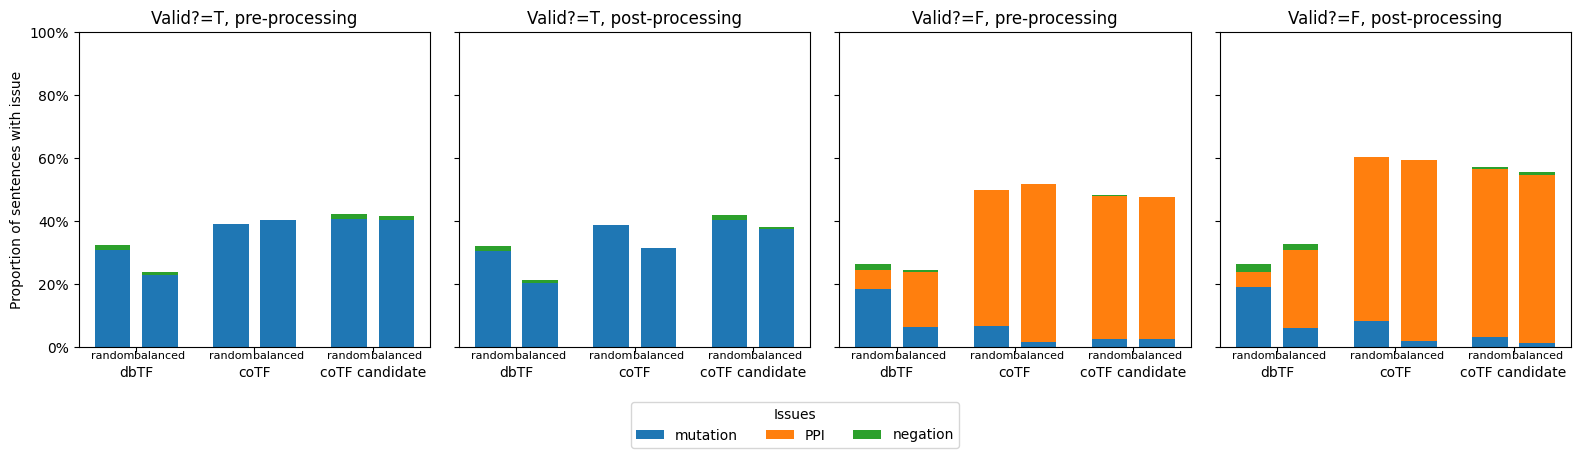

In [14]:
def plot_other_issues_by_combination(o_i_results, tf_types, figsize=(14, 4)):
    # Reset the index to use the index columns as regular columns
    o_i_results_reset = o_i_results.reset_index()

    # Define issues and tf_types
    issues = ['mutation', 'PPI', 'negation']
    hue = 'method'  # Random/Balanced will be the hue
    hue_levels = ['random', 'balanced']  # Ensure this order
    bar_width = 0.2
    group_width = bar_width * len(hue_levels) + 0.1
    withingroup_space = 0.05

    # Define combinations of Valid? and pre-post
    combinations = [
        {'Valid?': 'T', 'pre-post': 'pre'},
        {'Valid?': 'T', 'pre-post': 'post'},
        {'Valid?': 'F', 'pre-post': 'pre'},
        {'Valid?': 'F', 'pre-post': 'post'},
    ]

    # Create a plot for each combination
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 4), sharey=True)
    # axes = axes.flatten()

    for i, (ax, combination) in enumerate(zip(axes, combinations)):
        # Filter data for the current combination
        filtered = o_i_results_reset[
            (o_i_results_reset['Valid?'] == combination['Valid?']) &
            (o_i_results_reset['pre-post'] == combination['pre-post'])
        ]

        # Group data by tf_type and method
        grouped = filtered.groupby(['tf_type', hue])[issues].mean().reset_index()

        # Ensure tf_types and hue levels are consistent
        grouped['tf_type'] = pd.Categorical(grouped['tf_type'], categories=tf_types, ordered=True)
        grouped[hue] = pd.Categorical(grouped[hue], categories=hue_levels, ordered=True)
        grouped = grouped.sort_values(['tf_type', hue])

        # Set bar positions
        x = np.arange(len(tf_types)) * group_width

        # Plot stacked bars for each hue level
        for j, level in enumerate(hue_levels):
            level_data = grouped[grouped[hue] == level]

            # Initialize bottom values
            bottom = np.zeros(len(tf_types))

            # Plot each issue as a stacked segment
            for k, issue in enumerate(issues):
                ax.bar(
                    x + j * bar_width,  # Offset bars within the group
                    level_data[issue],
                    width=bar_width - withingroup_space,
                    bottom=bottom,
                    label=issue if j == 0 else "",
                    color=f'C{k}'
                )
                bottom += level_data[issue]

        # Add TF type labels below the bars
        ax.set_xticks(x + (bar_width * len(hue_levels) / 2) - bar_width / 2)
        ax.set_xticklabels(['' for _ in tf_types])  # Temporarily blank x-ticks

        # ax.set_xticklabels(tf_types)
        ax.set_title(f"Valid?={combination['Valid?']}, {combination['pre-post']}-processing")

        # # Add individual hue labels below each bar and move TF type labels further down
        ax.set_xticks(x + (bar_width * len(hue_levels) / 2) - bar_width / 2)  # Center the group


        # Add individual bar labels for the method
        for j, level in enumerate(hue_levels):
            for idx, tf_type in enumerate(tf_types):
                ax.text(
                    x[idx] + j * bar_width,  # Position based on the bar
                    -0.01,  # Move further down
                    f"{level}", ha="center", va="top", fontsize=8, rotation=0
                )

        # Add TF type labels below the hue labels
        for idx, tf_type in enumerate(tf_types):
            ax.text(
                x[idx] + (bar_width * (len(hue_levels) - 1) / 2),  # Center the label below the group
                -0.06,  # Move further down
                f"{tf_type}", ha="center", va="top", fontsize=10,
            )

        # Format the axes
        ax.set_ylim(0, 1)
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))

        if i == 0:
            ax.set_ylabel('Proportion of sentences with issue')

    # Add a single legend
    fig.legend(
        labels=issues, loc='lower center', ncol=len(issues), title="Issues",
        bbox_to_anchor=(0.5, -0.15), fontsize=10
    )

    # Adjust layout
    plt.tight_layout()
    plt.show()

plot_other_issues_by_combination(o_i_results, tf_types)

In [15]:
# RESULTS
def TRI_validation_results_table(validated_df):
    '''Make table with validation results. Only include TRUE labels'''

    # Only consider TRUE labels
    validated_df_true = validated_df[validated_df['Label'] == 'TRUE']

    results = []
    for tf_type in validated_df['TF_type'].cat.categories:
        for method in ['random', 'balanced']:
            for p in ['pre', 'post']:
                df = validated_df_true[(validated_df_true['TF_type'] == tf_type) & (validated_df_true['method'] == method) & (validated_df_true['pre-post'] == p)]
                
                r = {
                    'tf_type': tf_type,
                    'method': method,
                    'validation stage': p,
                    'num_sents': len(df)
                }

                # Get number of sentences with correct TRIs
                m_T_TRI_df = df['true_label'] == 'TRUE'
                r['Num correct TRIs'] = m_T_TRI_df.sum()

                # Get NER & norm stats
                r['NER'] = 1 - sum(((df[f'{T}_is_incorrect'].str.contains('NER')).sum() for T in ['TF', 'TG'])) / r['num_sents']
                r['NER-TF'] = 1 - (df[f'TF_is_incorrect'].str.contains('NER')).sum() / r['num_sents']
                r['NER-TG'] = 1 - (df[f'TG_is_incorrect'].str.contains('NER')).sum() / r['num_sents']

                r['norm'] = 1 - sum(((df[f'{T}_is_incorrect'].str.contains('norm')).sum() for T in ['TF', 'TG'])) / r['num_sents']
                r['norm-TF'] = 1 - (df[f'TF_is_incorrect'].str.contains('norm')).sum() / r['num_sents']
                r['norm-TG'] = 1 - (df[f'TG_is_incorrect'].str.contains('norm')).sum() / r['num_sents']

                # Get TRI stats
                r['TRI'] = 1 - (df['Label'] != df['true_label']).sum() / r['num_sents']

                # Get MoR stats - over those whose true_label is True
                # (1) Correctly labelled / all sentences
                MoR_df = df[m_T_TRI_df]
                r['MoR'] = len(MoR_df[(MoR_df['MoR'] == MoR_df['true_MoR'])]) / len(MoR_df)

                # Get final probability                
                r['Overall']  = ((df['Valid?'] == 'T') & df[f'TF_is_incorrect'].isna() & df[f'TG_is_incorrect'].isna() ).sum() / r['num_sents']

                # Get the breakdown of MoR labels
                # Precision: Correctly labelled / Sentences classified to that label
                for MoR in ['ACTIVATION', 'REPRESSION', 'UNDEFINED']:
                    r[MoR.capitalize()+" Precision"] = len(MoR_df[(MoR_df['MoR'] == MoR) & (MoR_df['MoR'] == MoR_df['true_MoR'])]) / len(MoR_df[(MoR_df['MoR'] == MoR)])
                
                # Recall: Correctly labelled / Sentences with that as the true label
                for MoR in ['ACTIVATION', 'REPRESSION', 'UNDEFINED']:
                    r[MoR.capitalize()+" Recall"] = len(MoR_df[(MoR_df['MoR'] == MoR) & (MoR_df['MoR'] == MoR_df['true_MoR'])]) / len(MoR_df[(MoR_df['true_MoR'] == MoR)])


                # Ensure num_sents is not treated as a float in the printed table
                r['num_sents'] = str(r['num_sents'])
                r['Num correct TRIs'] = str(r['Num correct TRIs'])

                results.append(r)
   

    return pd.DataFrame(results).set_index(['tf_type', 'method', 'validation stage']).T

def nonTRI_validation_results_table(validated_df):
    '''Make table with validation results. Only include random, post-processed results'''

    validated_df = validated_df[(validated_df['method'] == 'random') & (validated_df['pre-post'] == 'post')]

    results = []
    for tf_type in validated_df['TF_type'].cat.categories:
        df = validated_df[(validated_df['TF_type'] == tf_type)]
        
        r = {'tf_type': tf_type}

        for label, state in (['TRUE', 'TRI'], ['FALSE', 'not TRI']):
            total_num = len(df[df['Label'] == label])
            num_valid = len(df[(df['Label'] == label) & (df['Label'] == df['true_label'])])

            r[state] = f"{num_valid}/{total_num} ({num_valid / total_num:.2%})"

        results.append(r)
   

    return pd.DataFrame(results).set_index(['tf_type']).T

def show_general_statistics(validated_df):
    validated_unique = validated_df.drop_duplicates(subset=['#SentenceID'], keep='first')

    r = {}
    r['Total'] = {
        "Num validated sentences": len(validated_unique),
        "Num TRI validated sentences": len(validated_unique[validated_unique['Label'] == 'TRUE']),
        "Num Not TRI validated sentences": len(validated_unique[validated_unique['Label'] == 'FALSE']),
    }

    for TF in validated_df['TF_type'].cat.categories:
        r[TF] = {
            "Num validated sentences": len(validated_unique[validated_unique['TF_type'] == TF]),
            "Num TRI validated sentences": len(validated_unique[(validated_unique['TF_type'] == TF) & (validated_unique['Label'] == 'TRUE')]),
            "Num Not TRI validated sentences": len(validated_unique[(validated_unique['TF_type'] == TF) & (validated_unique['Label'] == 'FALSE')]),
        }

    display(pd.DataFrame(r))

    return

show_general_statistics(validated_df)

pd.set_option("display.float_format", "{:.1%}".format)

for results_table_f in (TRI_validation_results_table, nonTRI_validation_results_table):
    results_table = results_table_f(validated_df)
    h3(results_table_f.__name__)
    display(results_table)
    results_table.to_csv(f'tables/{results_table_f.__name__}.tsv', sep='\t')

,Total,dbTF,coTF,coTF candidate
Num validated sentences,3470,1766,369,1335
Num TRI validated sentences,3367,1720,350,1297
Num Not TRI validated sentences,103,46,19,38


<h3>TRI_validation_results_table</h3>

tf_type                dbTF                        coTF                  \
method               random       balanced       random        balanced   
validation stage        pre  post      pre  post    pre   post      pre   
num_sents               899   880      827   804    201    189      137   
Num correct TRIs        836   828      698   713    148    146       84   
NER                   98.4% 98.8%    97.3% 98.3%  99.0%  98.9%    97.1%   
NER-TF                99.1% 99.4%    98.1% 98.6%  99.0%  98.9%    97.1%   
NER-TG                99.3% 99.3%    99.3% 99.6% 100.0% 100.0%   100.0%   
norm                  95.1% 96.1%    94.2% 96.4%  98.5%  98.4%    94.2%   
norm-TF               98.8% 99.0%    96.6% 97.8%  99.0%  98.9%    95.6%   
norm-TG               96.3% 97.2%    97.6% 98.6%  99.5%  99.5%    98.5%   
TRI                   93.0% 94.1%    84.4% 88.7%  73.6%  77.2%    61.3%   
MoR                   90.9% 91.2%    96.3% 96.5%  96.6%  96.6%    94.0%   
Overall               79.9% 82.0%    76.9% 83.2%  71.1%  74.6%    57.7%   
Activation Precision  92.4% 92.6%    97.5% 98.3%  98.6%  98.6%    94.9%   
Repression Precision  83.6% 84.4%    91.9% 90.2%  93.0%  93.0%    90.9%   
Undefined Precision   94.0% 93.9%    98.3% 99.1%  97.0%  96.9%    95.7%   
Activation Recall     92.6% 92.8%    96.8% 96.4%  97.3%  97.2%   100.0%   
Repression Recall     92.7% 93.3%    98.3% 98.2% 100.0% 100.0%    95.2%   
Undefined Recall      87.0% 87.1%    94.2% 95.4%  91.4%  91.2%    84.6%   

tf_type                     coTF candidate                        
method                              random        balanced        
validation stage       post            pre   post      pre  post  
num_sents               153            740    669      572   563  
Num correct TRIs        105            423    411      346   354  
NER                   96.1%          97.4%  98.8%    98.3% 98.2%  
NER-TF                96.1%          97.6%  99.0%    98.6% 98.8%  
NER-TG               100.0%          99.9%  99.9%    99.7% 99.5%  
norm                  94.1%          95.7%  97.6%    95.6% 95.9%  
norm-TF               94.1%          97.0%  98.7%    97.4% 97.0%  
norm-TG              100.0%          98.6%  99.0%    98.3% 98.9%  
TRI                   68.6%          57.2%  61.4%    60.5% 62.9%  
MoR                   96.2%          96.5%  96.4%    97.1% 97.2%  
Overall               64.1%          53.2%  57.8%    56.6% 59.7%  
Activation Precision  96.1%          96.2%  96.1%    97.3% 97.7%  
Repression Precision  96.4%          94.7%  94.6%    95.1% 94.7%  
Undefined Precision   96.2%         100.0% 100.0%    98.8% 98.8%  
Activation Recall    100.0%          97.2%  97.1%    97.8% 97.7%  
Repression Recall     96.4%          94.7%  94.6%    94.0% 95.7%  
Undefined Recall      89.3%          97.5%  97.4%    98.8% 97.6%

<h3>nonTRI_validation_results_table</h3>

tf_type,dbTF,coTF,coTF candidate
TRI,828/880 (94.09%),146/189 (77.25%),411/669 (61.43%)
not TRI,45/46 (97.83%),19/19 (100.00%),38/38 (100.00%)


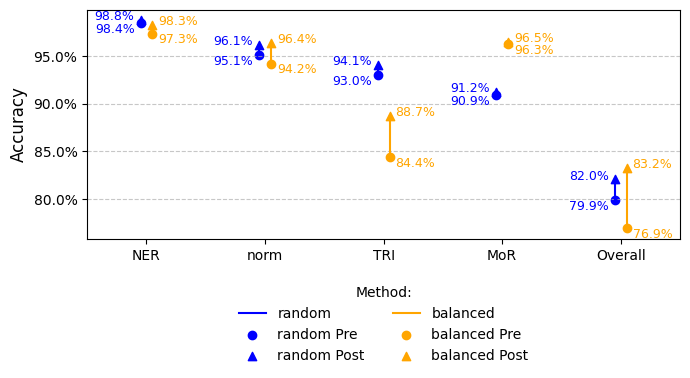

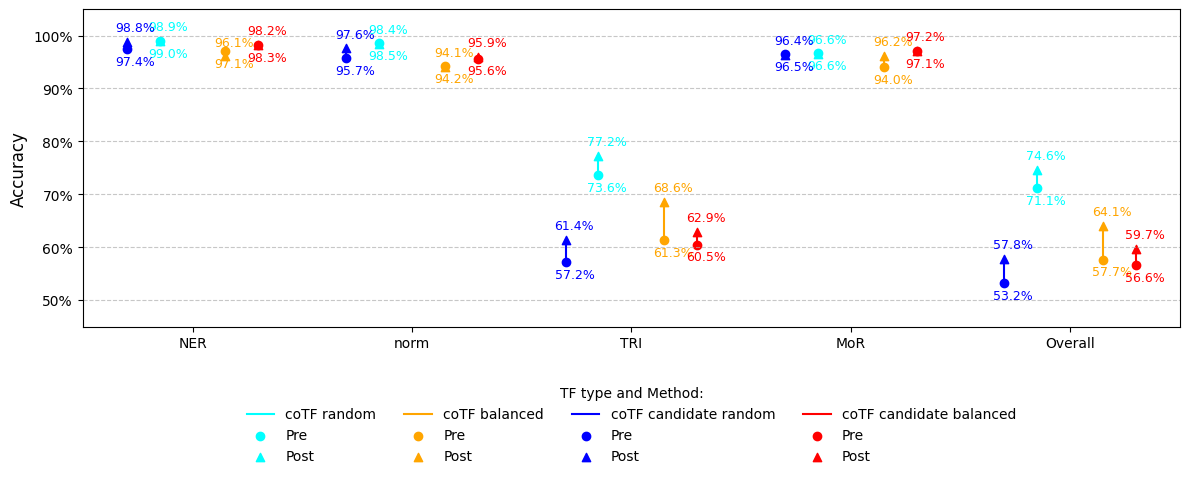

In [16]:
def make_validation_dotplot(results_table, TF_type = 'dbTF', y_sep = 0):

    XXTF_results_table = results_table[results_table['tf_type'] == TF_type]

    # Create the improved dot plot
    fig, ax = plt.subplots(figsize=(7, 4))

    cols = ['NER', 'norm', 'TRI', 'MoR', 'Overall']
    for i, col in enumerate(cols):

        # Add vertical lines for random and balanced
        for method, sep, color, orientation in [('random', -0.05, 'blue', 'right'), ('balanced', 0.05, 'orange', 'left')]: 

            # Get values for random and balanced for pre and post
            values = {}
            for pre_post in ['pre', 'post']:
                values[pre_post] = XXTF_results_table[(XXTF_results_table['method'] == method) & (XXTF_results_table['validation stage'] == pre_post)][col].values[0]

            ax.plot([i + sep, i + sep], [values['pre'], values['post']], color=color, label=method if i == 0 else "")
            ax.scatter([i + sep], [values['pre']], color=color, marker='o', label=f'{method} Pre' if i == 0 else "")
            ax.scatter([i + sep], [values['post']], color=color, marker='^', label=f'{method} Post' if i == 0 else "")

            # Add value labels next to the dots
            ax.text(i + sep*2, values['pre']-0.01-y_sep, f"{values['pre']:.1%}", fontsize=9, color=color, ha=orientation)
            ax.text(i + sep*2, values['post']+y_sep, f"{values['post']:.1%}", fontsize=9, color=color, ha=orientation)

    # Customize plot appearance
    ax.set_xticks(range(len(cols)))
    ax.set_xticklabels(cols)
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_xlim(-0.5, len(cols) - 0.5)
    # ax.set_ylim(0.7, 1.0)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    # ax.set_title('Pre- and Post-Processing Accuracy: Random vs Balanced Sampling', fontsize=14)
    ax.legend(title='Method:', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=10, frameon=False)

    # Add gridlines for readability
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

def make_coTF_validation_dotplot(results_table, y_sep = 0.03):

    # Create the improved dot plot
    fig, ax = plt.subplots(figsize=(12, 5))

    cols = ['NER','norm',  'TRI', 'MoR', 'Overall']

    for TF_type, x_sep in [('coTF', 0.15), ('coTF candidate', 0.3)]:

        XXTF_results_table = results_table[results_table['tf_type'] == TF_type]

        for i, col in enumerate(cols):

            # Add vertical lines for random and balanced
            for method, sep, orientation in [('random', -x_sep, 'right'), ('balanced', x_sep, 'left')]: 

                if TF_type == 'coTF':
                    color = 'aqua' if method == 'random' else 'orange'
                else:
                    color = 'blue' if method == 'random' else 'red'

                # Get values for random and balanced for pre and post
                values = {}
                for pre_post in ['pre', 'post']:
                    values[pre_post] = XXTF_results_table[(XXTF_results_table['method'] == method) & (XXTF_results_table['validation stage'] == pre_post)][col].values[0]

                ax.plot([i + sep, i + sep], [values['pre'], values['post']], color=color, label=f"{TF_type} {method}" if i == 0 else "")
                ax.scatter([i + sep], [values['pre']], color=color, marker='o', label=f'Pre' if i == 0 else "")
                ax.scatter([i + sep], [values['post']], color=color, marker='^', label=f'Post' if i == 0 else "")

                # Add value labels next to the dots
                ax.text(i + sep-0.05, values['pre']  - y_sep, f"{values['pre']:.1%}", fontsize=9, color=color)
                ax.text(i + sep-0.05, values['post'] + y_sep-0.01, f"{values['post']:.1%}", fontsize=9, color=color)

    # Customize plot appearance
    ax.set_xticks(range(len(cols)))
    ax.set_xticklabels(cols)
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_xlim(-0.5, len(cols) - 0.5)
    ax.set_ylim(0.45, 1.05)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    # ax.set_title('Pre- and Post-Processing Accuracy: Random vs Balanced Sampling', fontsize=14)
    ax.legend(title='TF type and Method:', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4, fontsize=10, frameon=False)

    # Add gridlines for readability
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()


TRI_results_table = TRI_validation_results_table(validated_df).T.reset_index()
make_validation_dotplot(TRI_results_table)
make_coTF_validation_dotplot(TRI_results_table)

COMMENT:
* MoR remains largely unaffected by whether it is pre, post, random or not random. It is constant.
* TRI, however, is more affected. Specially for dbTF, we see a drop of 10% in the accuracy of the model when calculating balanced datasets. A trend that is not observable in coTF. This shows that our model has been trained to somewhat learn the most popular TFs
* However, for coTF it doesn't change much, as it hasn't been trained on coTFs, proving even more that it has learned about the dbTFs to consider as positives. The model is therefore better at recalling more popular TFs than those that it hasn't seen on the training set.
* For the balanced, there is a big leap between pre- and post-, which I should try to find a way to understand
* NER and norm do not see much change between conditions: they're good independently of the frequency

### Negations - observations

In [17]:
# TODO - Astrid considered "Negation" as positive, and all instances of "Negations" are still TRUE.
# TODO - We are not consistent. There are 7 sentences marked as "Negation" and considered as FALSE (probably my fault). How do we solve this problem?
# I must change that in the validation, and comment on it as a limitation (it is bad at detecting Negations)

pd.options.display.max_colwidth = 1000
# Mask: TRI sentences flagged as "negation"
m = validated_df['Other issues'].str.contains('negation') & (validated_df['true_label'] == 'TRUE')
md(f"{m.sum()} rows are Negative but still have a TRUE label, coming from {set(validated_df[m]['stage'])}")
display(validated_df[m][['#SentenceID', 'Sentence', 'Label', 'MoR', 'Valid?', 'true_label', 'stage']])

# Mask: TRI sentences flagged as "negation"
m = validated_df['Other issues'].str.contains('negation') & (validated_df['true_label'] == 'FALSE')
md(f"{m.sum()} negative rows have a FALSE label, all coming from later stages: {set(validated_df[m]['stage'])}")
display(validated_df[m][['#SentenceID', 'Sentence', 'Label', 'MoR', 'Valid?', 'true_label', 'stage']])

pd.options.display.max_colwidth = 50

64 rows are Negative but still have a TRUE label, coming from {'s5_coTF', 's6_coTF', 's6_coTF_ll', 's4_dbTF', 's2', 's1', 's3'}

,#SentenceID,Sentence,Label,MoR,Valid?,true_label,stage
30,9010223:11:ETS2:Egr1,"However, the proteins ETS1, [TF], PEA3 and PU.1 were unable to form ternary complexes with SRF on either the [TG] or c-fos SREs.",TRUE,UNDEFINED,T,TRUE,s1
31,9010223:11:ETS2:c-fos,"However, the proteins ETS1, [TF], PEA3 and PU.1 were unable to form ternary complexes with SRF on either the Egr1 or [TG] SREs.",TRUE,UNDEFINED,T,TRUE,s1
165,17341303:9:NF-kappaB:CS-2,"CONCLUSION: Our present data suggest that [TF] is required for the transcription of mouse CS-1 but not [TG], and that the regulation of the calsarcins is mediated also by the NFAT and MEF2 transcription factors.",TRUE,ACTIVATION,T,TRUE,s1
171,15856012:6:p53:PEDF,"We discovered that the expression of pigment epithelium-derived factor ([TG]) was specifically induced by either p63 or p73, but not by [TF].",TRUE,ACTIVATION,T,TRUE,s1
191,21386060:9:STAT3:SOCS1,"In contrast, adenovirus-mediated expression of a dominant-negative STAT3 (F-[TF]) attenuated IFN-gamma-induced SOCS3 expression, reduction of IRS-1 protein, and suppression of insulin-induced glucose uptake but did not have any effect on the IFN-beta-mediated [TG] expression and inhibition of insulin-induced glucose uptake.",TRUE,ACTIVATION,F,TRUE,s1
...,...,...,...,...,...,...,...
5854,20878123:10:erbB2:PTEN,"On the other hand, [TG] expression at both mRNA and protein levels were not significantly affected by [TF] silencing (P>0.05).",TRUE,UNDEFINED,T,TRUE,s6_coTF_ll
5904,20430845:9:PTEN:HIF-1,"Strikingly, reintroducing the C2 domain of [TF] also resulted in a significant decrease in angiogenesis and VEGF expression, although it did not affect Akt phosphorylation or [TG] expression.",TRUE,REPRESSION,T,TRUE,s6_coTF_ll
6457,19336499:10:XBP1:IL-6,Knockdown of ATF6 but not [TF] partially inhibited DON-induced [TG] expression in the macrophages.,TRUE,ACTIVATION,T,TRUE,s1
6501,28364143:9:Pit1:GH,[TF] overexpression in attached cells could not induce [TG] production.,TRUE,ACTIVATION,T,TRUE,s2


7 negative rows have a FALSE label, all coming from later stages: {'s7_postnorm_coTF', 's7_prenorm_dbTF', 's6_coTF', 's7_postnorm_ll_coTF', 's7_postnorm_dbTF'}

,#SentenceID,Sentence,Label,MoR,Valid?,true_label,stage
2430,36543120:5:NUDT5:PARG,[TF] does not regulate PARP or [TG] activity.,TRUE,UNDEFINED,F,FALSE,s6_coTF
2971,15944155:4:AP-4:Bax,"Western blot analysis revealed that the expression of Bcl-xL, [TG], and Apaf-1 was not affected in cells transfected with sense or antisense [TF] genes.",TRUE,UNDEFINED,F,FALSE,s7_prenorm_dbTF
5673,36543120:5:NUDT5:PARG,[TF] does not regulate PARP or [TG] activity.,TRUE,UNDEFINED,F,FALSE,s6_coTF
6108,35248544:5:CNOT8:CNOT7,"In this study, we reveal a non-reciprocal effect of CNOT7 on CNOT8, in which CNOT8 protein is increased in the depletion of CNOT7 without corresponding changes in mRNA levels whereas [TG] is not affected by the loss of [TF].",TRUE,REPRESSION,F,FALSE,s7_postnorm_coTF
6166,11306047:11:ARNT:ALDH3,"Further, neither wild type nor dominant negative [TF] had effects on constitutive [TG] expression in corneal epithelial cells.",TRUE,UNDEFINED,F,FALSE,s7_postnorm_dbTF
6228,12374793:11:MKK3:PAI-1,"Furthermore, [TF] deficiency resulted in a selective disruption of TGF-beta1-stimulated up-regulation of pro-alpha1(I) collagen expression but not TGF-beta1 induction of fibronectin and [TG].",TRUE,ACTIVATION,F,FALSE,s7_postnorm_ll_coTF
6311,15944155:4:AP-4:Bax,"Western blot analysis revealed that the expression of Bcl-xL, [TG], and Apaf-1 was not affected in cells transfected with sense or antisense [TF] genes.",TRUE,UNDEFINED,F,FALSE,s7_prenorm_dbTF


## 3.2. The ExTRI2 resource

In [ ]:
# Show TF types in ExTRI2
TFs_df[TFs_df['In ExTRI'] == "True"]['updated TF type'].value_counts(dropna=False)

updated TF type
dbTF              2692
coTF candidate    2374
coTF               752
NaN                151
Name: count, dtype: int64

In [56]:
def split_in_dbTF_coTF_coTF_cand(ExTRI2_df):
    m_dbTF = ExTRI2_df['TF_type'].str.contains('dbTF')
    m_coTF = ExTRI2_df['TF_type'].apply(lambda x: 'coTF' in set(x.split(';'))) & ~m_dbTF
    m_coTF_cand = ExTRI2_df['TF_type'].str.contains('coTF candidate') & ~m_dbTF & ~m_coTF

    dbTF_df = ExTRI2_df[m_dbTF]
    coTF_df = ExTRI2_df[m_coTF]
    coTF_cand_df = ExTRI2_df[m_coTF_cand]

    # Check if the split was done correctly
    assert len(ExTRI2_df) == len(dbTF_df) + len(coTF_df) + len(coTF_cand_df)

    return dbTF_df, coTF_df, coTF_cand_df    

dbTF_df, coTF_df, coTF_cand_df = split_in_dbTF_coTF_coTF_cand(ExTRI2_df)

In [19]:
# TABLES 1, 2
def table_1(ExTRI2_df, dbTF_df, coTF_df, coTF_cand_df) -> dict:

    h3("Table 1")

    analysis_dfs = []
    for df, name in [(ExTRI2_df, 'Total'), (dbTF_df, 'dbTF'), (coTF_df, 'coTF'), (coTF_cand_df, 'coTF candidate')]:

        analytics = {}
        analytics['TRI-sentences'] = f"{len(df):,}"

        for mor in ['UNDEFINED', 'ACTIVATION', 'REPRESSION']:
            analytics[mor] = f"{len(df[df['MoR'] == mor]):,} ({len(df[df['MoR'] == mor])/len(df):.2%})"
        
        analytics['TG is not normalized'] = f"{(df['TG Id'].isna()).sum():,} ({(df['TG Id'].isna()).sum() / len(df):.2%})"
        analytics['Unique TRIs'] = f"{df['TRI Id'].nunique():,}"

        for T in ['TF', 'TG']:
            analytics[f'Unique {T} IDs'] = f"{df[f'{T} Id'].nunique():,}"
            analytics[f'Unique human {T} IDs'] = f"{df[df[f'{T} TaxID'] == '9606'][f'{T} Id'].nunique():,}"

        diff_species_m = df['TF TaxID'].apply(lambda x: set(x.split(';'))) != df['TG TaxID'].apply(lambda x: set(x.split(';')))
        analytics['TF & TG from different species'] = f"{diff_species_m.sum():,} ({diff_species_m.sum() / len(df):.2%})"

        # Convert the analytics dictionary to a DataFrame and add it to the list
        analysis_df = pd.DataFrame.from_dict(analytics, orient='index', columns=[name])
        analysis_dfs.append(analysis_df)

    display(pd.concat(analysis_dfs, axis=1))
    return 

def table_2(final_df, dbTF_df):

    # Obtained from other sources
    all_pmids = 38_776_000
    has_gene_entities = 6_507_211

    # Get the number of PMIDs in candidate sentences
    candidate_sents = pd.read_csv(config['raw_ExTRI2_p'], sep='\t', header=1, chunksize=1_000_000, keep_default_na=False)
    candidate_PMIDs = set()
    for chunk in candidate_sents:
        PMIDs = chunk['#SentenceID'].apply(lambda row: row.split(':')[1])
        candidate_PMIDs.update(PMIDs)

    has_TRIs = final_df['PMID'].nunique()
    has_dbTF_TRIs = dbTF_df['PMID'].nunique()

    h3("Table 2")
    analytics = {}
    analytics['All PMIDs'] = f"{all_pmids:,}"
    analytics['Has gene entities'] = f"{has_gene_entities:,} ({has_gene_entities / all_pmids:.2%})"
    analytics['Has candidate sentences'] = f"{len(candidate_PMIDs):,} ({len(candidate_PMIDs) / all_pmids:.2%})"
    analytics['Has TRIs'] = f"{has_TRIs:,} ({has_TRIs / all_pmids:.2%})"
    analytics['Has dbTF TRIs'] = f"{has_dbTF_TRIs:,} ({has_dbTF_TRIs / all_pmids:.2%})"


    analysis_df = pd.DataFrame.from_dict(analytics, orient='index', columns=['Num sentences'])
    # analysis_df.to_excel('tables_figs/table_1.xlsx')
    display(analysis_df)

    return 

table_1(ExTRI2_df, dbTF_df, coTF_df, coTF_cand_df)
table_2(ExTRI2_df, dbTF_df)

<h3>Table 1</h3>

,Total,dbTF,coTF,coTF candidate
TRI-sentences,"832,043","425,071","88,701","318,271"
UNDEFINED,"242,925 (29.20%)","137,293 (32.30%)","26,300 (29.65%)","79,332 (24.93%)"
ACTIVATION,"414,620 (49.83%)","207,625 (48.84%)","38,378 (43.27%)","168,617 (52.98%)"
REPRESSION,"174,498 (20.97%)","80,153 (18.86%)","24,023 (27.08%)","70,322 (22.10%)"
TG is not normalized,0 (0.00%),0 (0.00%),0 (0.00%),0 (0.00%)
Unique TRIs,"282,440","140,163","35,555","106,722"
Unique TF IDs,"7,013","3,284",914,"2,815"
Unique human TF IDs,"2,725","1,261",380,"1,084"
Unique TG IDs,"25,725","20,395","9,769","17,211"
Unique human TG IDs,"12,362","10,234","5,637","8,767"


/tmp/ipykernel_1847/2086684210.py:41: DtypeWarning: Columns (6,7,10) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in candidate_sents:


<h3>Table 2</h3>

,Num sentences
All PMIDs,"38,776,000"
Has gene entities,"6,507,211 (16.78%)"
Has candidate sentences,"301,149 (0.78%)"
Has TRIs,"291,851 (0.75%)"
Has dbTF TRIs,"159,254 (0.41%)"


<h3>Figure 2</h3>

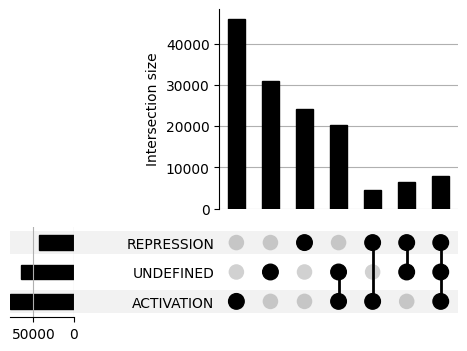

<h3>Table S1</h3>

,Counts
ACTIVATION,"46,035 (32.84%)"
REPRESSION,"24,051 (17.16%)"
UNDEFINED,"30,879 (22.03%)"
"ACTIVATION,REPRESSION","4,492 (3.20%)"
"ACTIVATION,UNDEFINED","20,237 (14.44%)"
"REPRESSION,UNDEFINED","6,551 (4.67%)"
"ACTIVATION,REPRESSION,UNDEFINED","7,918 (5.65%)"
1 MoR,"100,965 (72.03%)"
2 MoR,"31,280 (22.32%)"
3 MoR,"7,918 (5.65%)"


In [20]:
# FIGURE 2 & TABLE S1
def figure_2(df):
    # 1. Get the sets of TRIs for each MoR

    # Create a set of TRIs for each MoR
    A_set = set(df[df["MoR"] == 'ACTIVATION']['TRI Id'])
    R_set = set(df[df["MoR"] == 'REPRESSION']['TRI Id'])
    U_set = set(df[df["MoR"] == 'UNDEFINED']['TRI Id'])
    # 2. Get the union of these sets
    MoR_listoflists = [
        ['ACTIVATION'], ['REPRESSION'], ['UNDEFINED'],
        ['ACTIVATION', 'REPRESSION'],
        ['ACTIVATION', 'UNDEFINED'],
        ['REPRESSION', 'UNDEFINED'],
        ['ACTIVATION', 'REPRESSION', 'UNDEFINED']
    ]
    MoR_counts = [
        len(A_set - R_set - U_set), 
        len(R_set - A_set - U_set), 
        len(U_set - R_set - A_set),
        len((A_set & R_set) - U_set),
        len((A_set & U_set) - R_set),
        len((U_set & R_set) - A_set),
        len(A_set & R_set & U_set),    
    ]

    # Ignore warnings for upsetplot: it has a lot (library seems like is not updated)
    warnings.filterwarnings('ignore')
    example = upsetplot.from_memberships(MoR_listoflists, data=MoR_counts)
    upsetplot.plot(example)  # doctest: +SKIP
    h3("Figure 2")
    # plt.title("")
    plt.show()
    warnings.filterwarnings('default')

    return MoR_counts, MoR_listoflists

def table_S1(MoR_counts, MoR_listoflists):
    h3("Table S1")
    MoR_counts_table = {}
    for label, count in zip(MoR_listoflists, MoR_counts):
        MoR_counts_table[",".join(label)] = count

    MoR_counts_table['1 MoR'] = sum([MoR_counts_table[MoR] for MoR in ['ACTIVATION', 'REPRESSION', 'UNDEFINED']])
    MoR_counts_table['2 MoR'] = sum([MoR_counts_table[MoR] for MoR in ['ACTIVATION,REPRESSION', 'ACTIVATION,UNDEFINED', 'REPRESSION,UNDEFINED']])
    MoR_counts_table['3 MoR'] = MoR_counts_table['ACTIVATION,REPRESSION,UNDEFINED']
    TOTAL = sum([MoR_counts_table[f'{n} MoR'] for n in range(1, 4)])

    for key, value in MoR_counts_table.items():
        MoR_counts_table[key] = f"{value:,} ({value / TOTAL:.2%})"

    display(pd.DataFrame.from_dict(MoR_counts_table, orient='index', columns=['Counts']))

MoR_counts, MoR_listoflists = figure_2(dbTF_df)
table_S1(MoR_counts, MoR_listoflists)

24309 (2.92%) sentences are not considered in the analysis as their TF/TG is mapped to +1 ID
There are 0 human TFs and 83 human TGs in ExTRI2 that are not found in the all_human_genes df.
There are 85 human genes in ExTRI2 that are not found in the all_human_genes df (thus, outdated IDs)
They appear in 423 rows, which are excluded from the TG distribution analysis, but kept for the rest of analysis.


Number of genes retrieved by category, considering direct human, and mouse/rat orthologs

,human,orthologs,unique,orth.unique,% uniq.,% orth.uniq.
Total,286692,421367,10125,14127,5.3%,10.6%
PROTEIN_CODING,276917,365020,9140,9840,44.4%,47.8%
ncRNA,8107,9759,807,812,3.7%,3.7%
PSEUDO,820,864,107,117,0.6%,0.7%
OTHER,728,598,37,30,4.4%,3.6%
snoRNA,21,24,10,12,0.8%,1.0%
tRNA,43,43,8,8,1.2%,1.2%
snRNA,30,30,7,7,4.2%,4.2%
BIOLOGICAL_REGION,15,0,6,0,0.0%,0.0%
rRNA,1,1,1,1,0.1%,0.1%


<span style='color:red'>There are 2 dbTFs that are non considered to be protein-coding, but are kept in the analysis.

,NCBI GeneID,Symbol,Gene Type,Taxonomic Name,Description
11907,100288711,DUX4L9,PSEUDO,Homo sapiens,double homeobox ...
17113,58160,NFE4,ncRNA,Homo sapiens,"nuclear factor, ..."


Number of retrieved human dbTFs

,unique,%
all considered,1789,100.0%
retrieved directly,1261,70.5%
retrieved (including orthologs),1311,73.3%


<h3>Figure 3</h3>

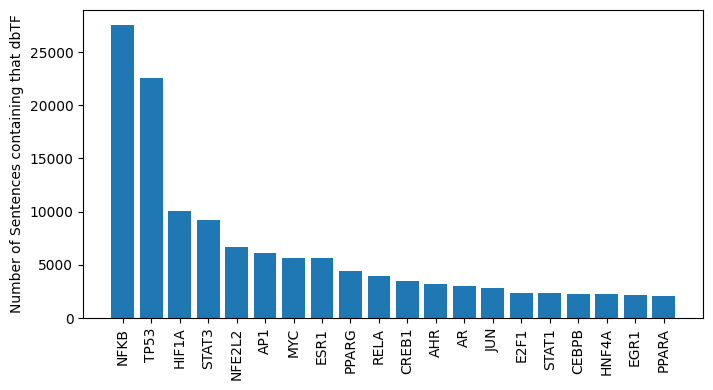

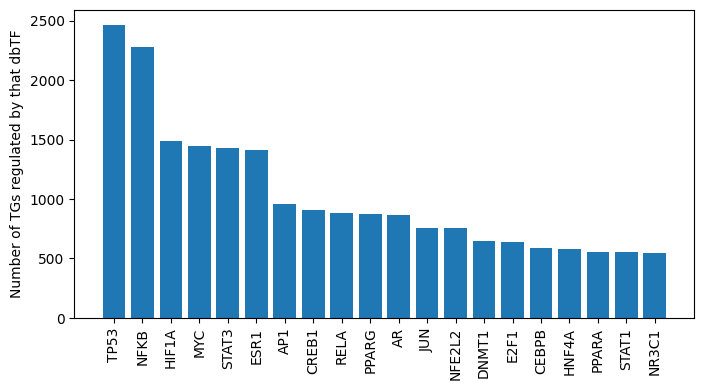

In [52]:
def load_all_human_genes():
    # Load all human TGs
    # downloaded from: https://www.ncbi.nlm.nih.gov/datasets/gene/taxon/9606/
    all_human_genes = pd.read_csv(config['all_human_TGs_p'], sep='\t', header=0, dtype=str)
    all_human_genes = all_human_genes[['NCBI GeneID', 'Symbol', 'Gene Type', 'Taxonomic Name', 'Description']]
    all_human_genes.loc[all_human_genes['Gene Type'].isna(), 'Gene Type'] = 'nan'

    # Add AP1 and NFKB complexes
    all_human_genes = pd.concat([all_human_genes, pd.DataFrame({
        'NCBI GeneID': ['Complex:AP1', 'Complex:NFKB'], 
        'Symbol': ['AP1', 'NFKB'],
        'Description': ['', ''],
        'Taxonomic Name': ['Homo sapiens', 'Homo sapiens'],
        'Gene Type': ['PROTEIN_CODING', 'PROTEIN_CODING'],
        })], ignore_index=True)
    
    # Ensure the data is expected: all human, no duplicate IDs
    assert all_human_genes['Taxonomic Name'].nunique() == 1
    assert all_human_genes['Taxonomic Name'].unique()[0] == 'Homo sapiens'
    assert (all_human_genes['NCBI GeneID'].duplicated()).sum() == 0 

    return all_human_genes

def display_TG_distribution(dbTF_df: pd.DataFrame, all_human_genes: pd.DataFrame) -> None:
    '''Display how many TGs we have retrieved'''

    # Get human TGs
    human_dbTF_df = dbTF_df[(dbTF_df['TG TaxID'] == '9606')] 

    m_TG_id = human_dbTF_df['TG Id'].isin(all_human_genes['NCBI GeneID'])
    print(f"There are {len(human_dbTF_df[~m_TG_id]['TG Id'].unique())} human genes in ExTRI2 that are not found in the all_human_genes df (thus, outdated IDs)")
    print(f"They appear in {(~m_TG_id).sum()} rows, which are excluded from the TG distribution analysis, but kept for the rest of analysis.")
    human_dbTF_df = human_dbTF_df[m_TG_id]

    # Initialise dict    
    TG_types = {}
    TG_types['Total'] = {
        'human': len(human_dbTF_df),
        'orthologs': len(dbTF_df),
        'unique': len(human_dbTF_df['TG Id'].unique()),
        'orth.unique': len(dbTF_df['TG_human_entrez_gene'].unique()),
        '% uniq.': f"{len(human_dbTF_df['TG Id'].unique()) / len(all_human_genes):.1%}",
        '% orth.uniq.': f"{len(dbTF_df['TG Id'].unique()) / len(all_human_genes):.1%}"
    }

    # Fill in dict
    for gene_type in all_human_genes['Gene Type'].unique():
        human_genes_of_gene_type = all_human_genes[all_human_genes['Gene Type'] == gene_type]['NCBI GeneID']

        human_sents = human_dbTF_df[human_dbTF_df['TG Id'].isin(human_genes_of_gene_type)]
        ortholog_sents = dbTF_df[dbTF_df['TG_human_entrez_gene'].isin(human_genes_of_gene_type)]
        TG_types[gene_type] = {
            'human': len(human_sents),
            'orthologs': len(ortholog_sents),
            'unique': len(human_sents['TG Id'].unique()),
            'orth.unique': len(ortholog_sents['TG_human_entrez_gene'].unique()),
        }
        TG_types[gene_type]['% uniq.']      = f"{TG_types[gene_type]['unique'] / len(human_genes_of_gene_type):.1%}"
        TG_types[gene_type]['% orth.uniq.'] = f"{TG_types[gene_type]['orth.unique'] / len(human_genes_of_gene_type):.1%}"


    # Convert to dataframe & display
    md("Number of genes retrieved by category, considering direct human, and mouse/rat orthologs")
    display(pd.DataFrame.from_dict(TG_types, orient='index').sort_values(by='unique', ascending=False))

def display_TF_distribution(dbTF_df: pd.DataFrame, all_human_genes: pd.DataFrame, dbTFs_set: set) -> None:

    human_dbTF_df = dbTF_df[(dbTF_df['TF TaxID'] == '9606')] 

    # Get all retrieved human dbTFs
    retrieved_TF_IDs = set(human_dbTF_df['TF Id'])

    # Ensure retrieved dbTFs are in the original list of dbTFs
    assert retrieved_TF_IDs.issubset(dbTFs_set), "Some dbTFs are not part of the original dbTFs list: {}".format(retrieved_TF_IDs - dbTFs_set)

    # Ensure they are all in the list of human genes
    assert retrieved_TF_IDs.issubset(set(all_human_genes['NCBI GeneID'])), "Some dbTFs are not part of the NCBI df"

    # Check if they are all protein-coding genes
    non_protein_coding_dbTFs = retrieved_TF_IDs - set(all_human_genes[all_human_genes['Gene Type'] == 'PROTEIN_CODING']['NCBI GeneID'])
    md(f"<span style='color:red'>There are {len(non_protein_coding_dbTFs)} dbTFs that are non considered to be protein-coding, but are kept in the analysis.")
    display(all_human_genes[all_human_genes['NCBI GeneID'].isin(non_protein_coding_dbTFs)])

    # Get the set of human dbTFs
    human_dbTFs_set = dbTFs_set.intersection(set(all_human_genes['NCBI GeneID']))

    # Prepare the dataframe to display, with counts and percentages
    human_dbTF_summary = {
        category: {
            "unique": count,
            "%": f"{count / len(human_dbTFs_set):.1%}"
        }
        for category, count in {
            'all considered': len(human_dbTFs_set),
            'retrieved directly': len(human_dbTF_df['TF Id'].unique()),
            'retrieved (including orthologs)': len(dbTF_df[~dbTF_df['TF_human_entrez_gene'].str.contains(';')]['TF_human_entrez_gene'].unique())
        }.items()
    }

    md("Number of retrieved human dbTFs")
    display(pd.DataFrame.from_dict(human_dbTF_summary, orient='index'))

def figure_3(human_dbTF_df):
    '''Plot the most common dbTFs'''

    h3("Figure 3")

    # Plot the most common dbTFs
    def plot_counts(df, ylabel):
        counts = df['TF Symbol'].value_counts()
        plt.figure(figsize=(8,4))
        plt.bar(counts[:20].index, counts[:20])
        plt.xticks(rotation='vertical')
        plt.ylabel(ylabel)

    # Plot dbTFs that appear in most sentences
    plot_counts(human_dbTF_df, "Number of Sentences containing that dbTF")
    
    # Plot dbTFs that are associated with the most TGs
    unique_TRIs = human_dbTF_df.drop_duplicates(subset='TRI Id', keep='first')
    plot_counts(unique_TRIs, "Number of TGs regulated by that dbTF")
    plt.show()    

def human_TF_TG_analysis(ExTRI2_df: pd.DataFrame, TFs_df: pd.DataFrame) -> None:
    '''Check the category of the found TGs'''

    # Load dataframe of all human genes
    all_human_genes = load_all_human_genes()

    # Show how many sentences have multiple mappings
    multiple_mapped = ((ExTRI2_df['TF Id'].str.contains(';')) | (ExTRI2_df['TG Id'].str.contains(';'))).sum()
    print(f"{multiple_mapped} ({multiple_mapped / len(ExTRI2_df):.2%}) sentences are not considered in the analysis as their TF/TG is mapped to +1 ID")

    # Filter ExTRI2 by only those containing human dbTFs (ignore those mapped to +1 ids)
    dbTF_df = ExTRI2_df[ExTRI2_df['TF_type'] == 'dbTF']
    human_dbTF_df = dbTF_df[(dbTF_df['TG TaxID'] == '9606') & (dbTF_df['TF TaxID'] == '9606')] 

    # Discard human TGs that are not found in the NCBI human genes df
    m_TF_id = human_dbTF_df['TF Id'].isin(all_human_genes['NCBI GeneID'])
    not_found_human_TF = human_dbTF_df[~m_TF_id]['TF Id'].unique()

    m_TG_id = human_dbTF_df['TG Id'].isin(all_human_genes['NCBI GeneID'])
    not_found_human_TG = human_dbTF_df[~m_TG_id]['TG Id'].unique()

    print(f"There are {len(not_found_human_TF)} human TFs and {len(not_found_human_TG)} human TGs in ExTRI2 that are not found in the all_human_genes df.")

    # Get set of all considered dbTFs
    dbTFs_set = set(TFs_df[TFs_df['updated TF type'] == 'dbTF']['Gene ID']) | {'Complex:NFKB', 'Complex:AP1'}

    # Show how many TGs and TFs we've obtained
    display_TG_distribution(dbTF_df, all_human_genes)
    display_TF_distribution(dbTF_df, all_human_genes, dbTFs_set)

    # Plot counts
    figure_3(human_dbTF_df)

    return

human_TF_TG_analysis(ExTRI2_df, TFs_df)

## Supp. File. Post-processing

**Post-processing and normalization scripts** in [postprocessing.py](../scripts/postprocessing/postprocessing.py) and [postprocessing_checkings.ipynb](../scripts/postprocessing/postprocessing_checkings.ipynb)
